# 1. Aligning double-ended DTS measurements <a id="top"></a>
_Notebook created by Davíd Brakenhoff, Artesia, March 2020_

<hr>

## Goal
This notebook reads the raw DTS double-ended measurements, aligns the forward and reverse channels and adds the reference probe data to the datastore. The result is stored as a netCDF file.

## Contents:
- [User settings](#1)
- [Load data](#2)
- [Align data](#3)
- [Export result to netCDF](#4)

<hr>

Import the requisite packages:

In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import dtscalibration as dts
from dtscalibration.datastore_utils import (shift_double_ended,
                                            suggest_cable_shift_double_ended)

C:\Users\dbrak\Anaconda3\envs\dts\lib\typing.py:898: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


## [User settings](#top)<a id="1"></a>
The settings below can be changed to control the script i.e. 
- which channel to load,
- which name to give the aligned data
- where to store the resulting netCDF file
- whether to save figures, and the directory in which to save them

In [2]:
# Script control
channel = "ch1"
netcdf_name = f"nyankpala_campaign1b_{channel}"
savefig = True
figdir = "./fig"

Paths to the directories containing the raw data:

In [7]:
# DTS dataset
directory = ("../../data/NYAN Double Ended Measurement_Aug 2019"
             "/NYAN30AUG2019/channel 1/2003\jan")

In [8]:
# Reference bath probe data
baths_dir = "../../data/nyankpala/baths"

The sensornet DTS machine used for this campaign always sets the date to January 4, 2003, therefore a correction is needed to get the correct timestamps for the data.

In [9]:
# start time according to DTS
t0data = pd.Timestamp('2003-01-04 21:01:18').to_numpy()

# actual start time
t0 = pd.Timestamp('2019-08-24 10:58:00').to_numpy()

## [Load data](#top)<a id="2"></a>

In [10]:
# %% Load DTS data
ds = dts.read_sensornet_files(directory=directory)

# Correct the timestamp
delta_t = np.datetime64(t0) - t0data
ds['time'] = ds.time + delta_t

963 files were found, each representing a single timestep
Recorded at 978 points along the cable
The measurement is double ended


Load in reference baths data (.txt files, comma seperated) and add to datastore

In [11]:
# Define time corrections
dt_ambient = pd.Timedelta(hours=-1)
dt_cold = pd.Timedelta(hours=+1)
dt_earth = pd.Timedelta(hours=-3, minutes=-42)

# ambient bath
df_ambient = pd.read_csv(os.path.join(
    baths_dir, 'warm_bath.txt'), delimiter=',')
df_ambient = df_ambient.rename(
    columns={'Time': 'time', 'Temperature': 'ambient'})
df_ambient.time = [datetime.strptime(
    x, '%Y-%m-%d %H:%M:%S.%f') for x in df_ambient.time.astype(str)]
df_ambient['time'] = df_ambient.time + dt_ambient
df_ambient = df_ambient.set_index('time')
ds_ambient = df_ambient.to_xarray()

# earth bath
df_earth = pd.read_csv(os.path.join(
    baths_dir, 'earth_bath.txt'), delimiter=',')
df_earth = df_earth.rename(columns={'Time': 'time', 'Temperature': 'earth'})
df_earth.time = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
                 for x in df_earth.time.astype(str)]
df_earth['time'] = df_earth.time + dt_earth
df_earth = df_earth.set_index('time')
ds_earth = df_earth.to_xarray()

# cold bath
df_cold = pd.read_csv(os.path.join(
    baths_dir, 'cold_bath.txt'), delimiter=',')
df_cold = df_cold.rename(columns={'Time': 'time', 'Temperature': 'cold'})
df_cold.time = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
                for x in df_cold.time.astype(str)]
df_cold['time'] = df_cold.time + dt_cold
df_cold = df_cold.set_index('time')
ds_cold = df_cold.to_xarray()

ds_ref = xr.merge([ds_ambient,
                   ds_earth,
                   ds_cold])

# resample to 1 minute
ds_ref = ds_ref.resample(time='1min').mean(dim='time')

C:\Users\dbrak\Anaconda3\envs\dts\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Add the reference temperatures to DTS datastore

In [12]:
ds_ref2 = ds_ref.reindex({'time': ds.time}, method='nearest')
ds['ambient'] = ds_ref2.ambient
ds['cold'] = ds_ref2.cold
ds['earth'] = ds_ref2.earth

Plot reference temperatures in baths and highlight DTS observation period.

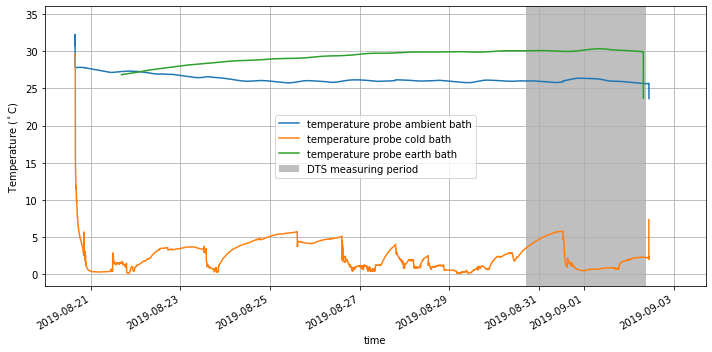

In [13]:
# plot reference temperature in baths
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ds_ref.ambient.plot(ax=ax, label="temperature probe ambient bath")
ds_ref.cold.plot(ax=ax, label="temperature probe cold bath")
ds_ref.earth.plot(ax=ax, label="temperature probe earth bath")
ax.grid(b=True)
timespan = ds.isel({"time": [0, -1]})["time"].to_index()
ax.axvspan(*timespan.to_list(), facecolor="gray", alpha=0.5,
           label="DTS measuring period")

# timeslice = ["2019-08-28 22:00", "2019-08-29 21:00"]
# ax.axvspan(*timeslice, facecolor="red", alpha=0.5,
#            label="calibration period for determining gamma")
# ax.set_ylim(top=6)

ax.set_ylabel("Temperature ($^\circ$C)")
ax.legend(loc="best")
fig.tight_layout()
if savefig:
    # fig.savefig(os.path.join(figdir, "temp_baths_for_fixedgamma.png"), dpi=150)
    fig.savefig(os.path.join(figdir, "temp_baths.png"), dpi=150)

## [Align data](#top)<a id="3"></a>
Let `dtscalibration` package suggest a cable shift and apply this suggestion to the dataset.

I dont know what to do with the following data ['TMP']
I dont know what to do with the following data ['TMP']
I dont know what to do with the following data ['TMP']


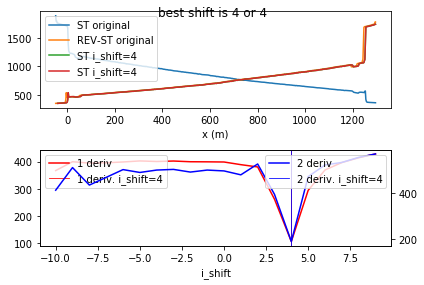

In [14]:
# %% Shift data to line up the forward/reverse channels
shift1, shift2 = suggest_cable_shift_double_ended(ds, irange=range(-10, 10))
ds = shift_double_ended(ds, shift1)

Plot to check whether lining up reverse/forward signals is correct

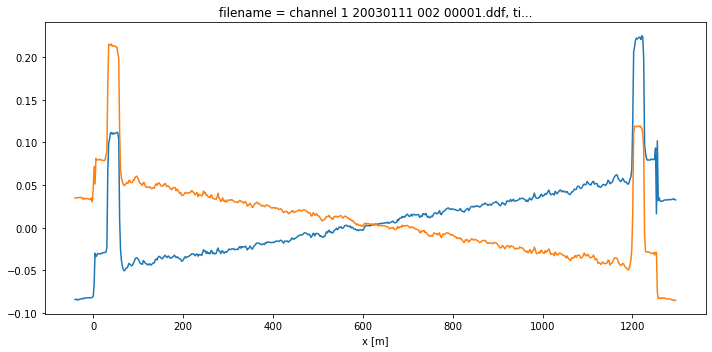

In [15]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
np.log(ds["st"] / ds['ast']).isel(time=0).plot(ax=ax)
np.log(ds['rst'] / ds['rast']).isel(time=0).plot(ax=ax)
fig.tight_layout()
if savefig:
    fig.savefig(os.path.join(figdir, f"check_lining_up_data_{channel}.png"))

## [Export result to netCDF](#top)<a id="4"></a>

In [ ]:
# remove illegal character in attribute: '/'
val = ds.attrs.pop('default loss term (dB/km)')
ds.attrs['default loss term (dB \\ km)'] = val

ds.to_netcdf(path=f"../data/nc/{netcdf_name}.nc", format="NETCDF4")